# Physical Performance Metric
##### Initially, the idea was to analyze high-risk movements. However, due to the lack of injury data in the dataset, I shifted the focus to performance metrics instead.

In [1]:
import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.visualisations import bland_altman_plot, plot_actual_vs_predicted
from src.utils import filter_by_frequency, split_time_series_data
from src.feature_engineering import compute_performance_score, NormalizePerformanceScoreTransformer, \
    LaggedFeaturesTransformer, ShiftPerformanceScoreTransformer

# Read and clean the data
df = (
    pl.read_csv("../data/raw/anonymous.csv")
    .with_columns(pl.col("date").str.strptime(pl.Date, "%d/%m/%Y"))
    .with_columns((pl.col("ima_cod_left") + pl.col("ima_cod_right")).alias('ima_cod'))
    .filter(pl.col('duration') >= 30)  # Removing practice with too short a duration
    .pipe(filter_by_frequency, 100)  # Removing players with too few data point.
)

# Define weights
weights = {
    'total_distance_m': 0.05,
    'total_player_load': 0.25,
    'acc_2m_s_s_total_efforts': 0.1,
    'acc_3m_s_s_total_efforts': 0.1,
    'dec_2m_s_s_total_efforts': 0.1,
    'dec_3m_s_s_total_efforts': 0.1,
    'high_intensity_distance_m_v5_v6_m': 0.25,
    'sprint_distance_m_m': 0.05,
    'maximum_velocity_km_h': 0.05,
    'ima_cod': 0.1
}

# Normalize metrics by duration - this step is important as the duration varied quite a bit.
df = df.with_columns([
    (pl.col(col) / pl.col('duration')).alias(f'{col}_per_min') for col in weights.keys() if
    col != 'maximum_velocity_km_h'
])

# Compute the performance score based on the weights
df = compute_performance_score(df, weights)

# Save the processed dataset
df.write_csv("../data/processed/df_with_performance_scores.csv")

# Sort dataframe to ensure we can split correctly on a date using a float value.
df = df.sort(by=["player", "date"], descending=False)
df_pd = df.to_pandas()
train_df, test_df = split_time_series_data(df_pd, split_criterion=0.2)

# Define preprocessing steps as classes to ensure compatibility with scikit-learn's Pipeline.
lagged_transformer = LaggedFeaturesTransformer(weights=weights)
normalize_performance_transformer = NormalizePerformanceScoreTransformer()
shift_performance_transformer = ShiftPerformanceScoreTransformer()

# Create the preprocessor pipeline
feature_engineering_pipeline = Pipeline(steps=[
    ('lagged', lagged_transformer),
    ('normalize_performance', normalize_performance_transformer),
    ('shift_performance', shift_performance_transformer),
])

# Apply preprocessing to training and test data to create features and targets
train_df = feature_engineering_pipeline.fit_transform(train_df)
test_df = feature_engineering_pipeline.transform(test_df)

# Define the features and target
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_cols if
                      col not in ['performance_score_next', 'performance_score', 'duration']]
categorical_features = ['position']
X_train = train_df[numerical_features + categorical_features]
y_train = train_df['performance_score_next']
X_test = test_df[numerical_features + categorical_features]
y_test = test_df['performance_score_next']

In [2]:
# Create preprocessor that standardscales numerical features and onehot-encodes categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Train, predict, evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 12.18071000855432
Root Mean Squared Error: 3.4900873926814957
R-squared: 0.1305867378878226


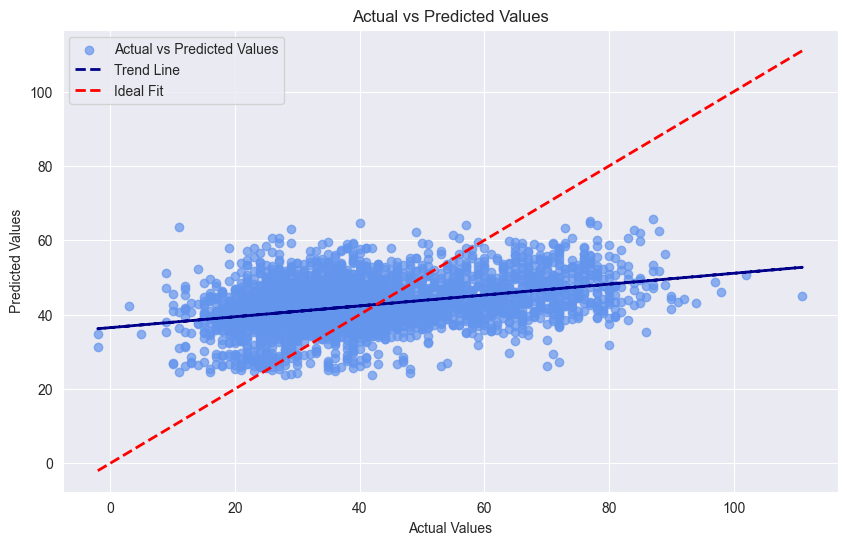

In [3]:
# Plotting the results with an actual vs predicted plot
plot_actual_vs_predicted(y_test, y_pred)

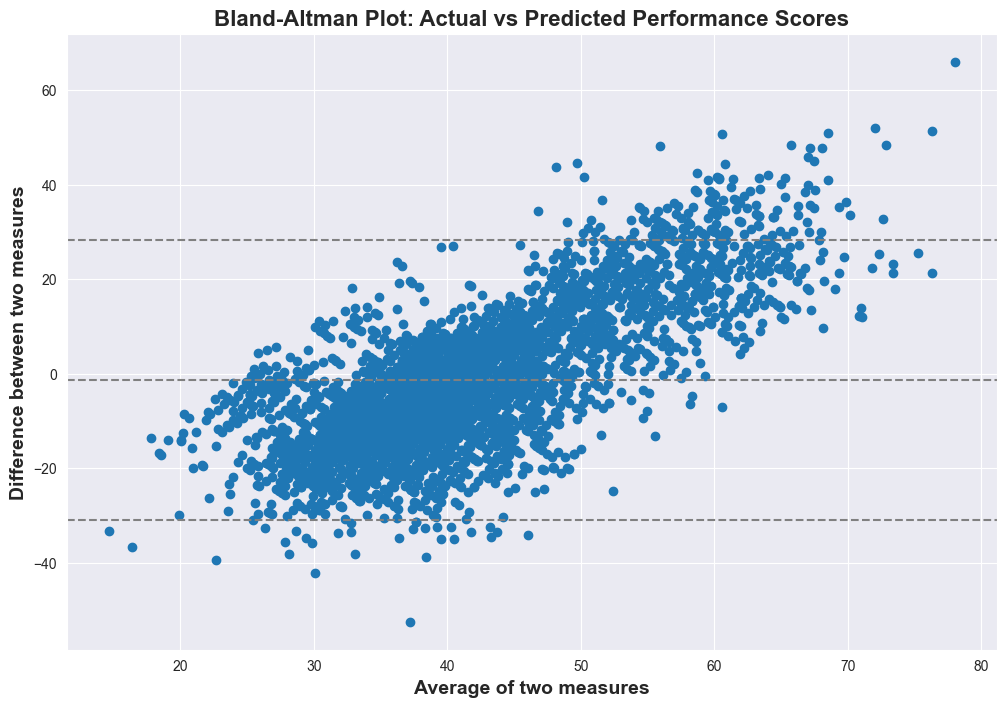

In [4]:
# plotting the results with a blandt-altman plot
bland_altman_plot(y_test, y_pred, plottitle='Bland-Altman Plot: Actual vs Predicted Performance Scores')

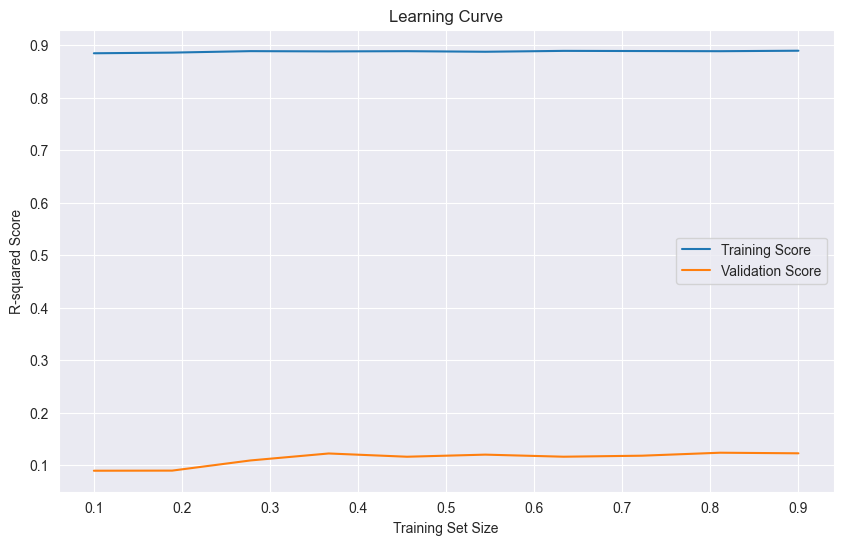

In [8]:
# Creating a model learning curve to indicate the issue.
# Bottom line is, the model didn't learn anything...
train_sizes = np.linspace(0.1, 0.9, 10)  # Use values less than 1.0 for train_size
train_scores = []
validation_scores = []
for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    pipeline.fit(X_train_subset, y_train_subset)
    train_scores.append(pipeline.score(X_train_subset, y_train_subset))
    validation_scores.append(pipeline.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Training Score')
plt.plot(train_sizes, validation_scores, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

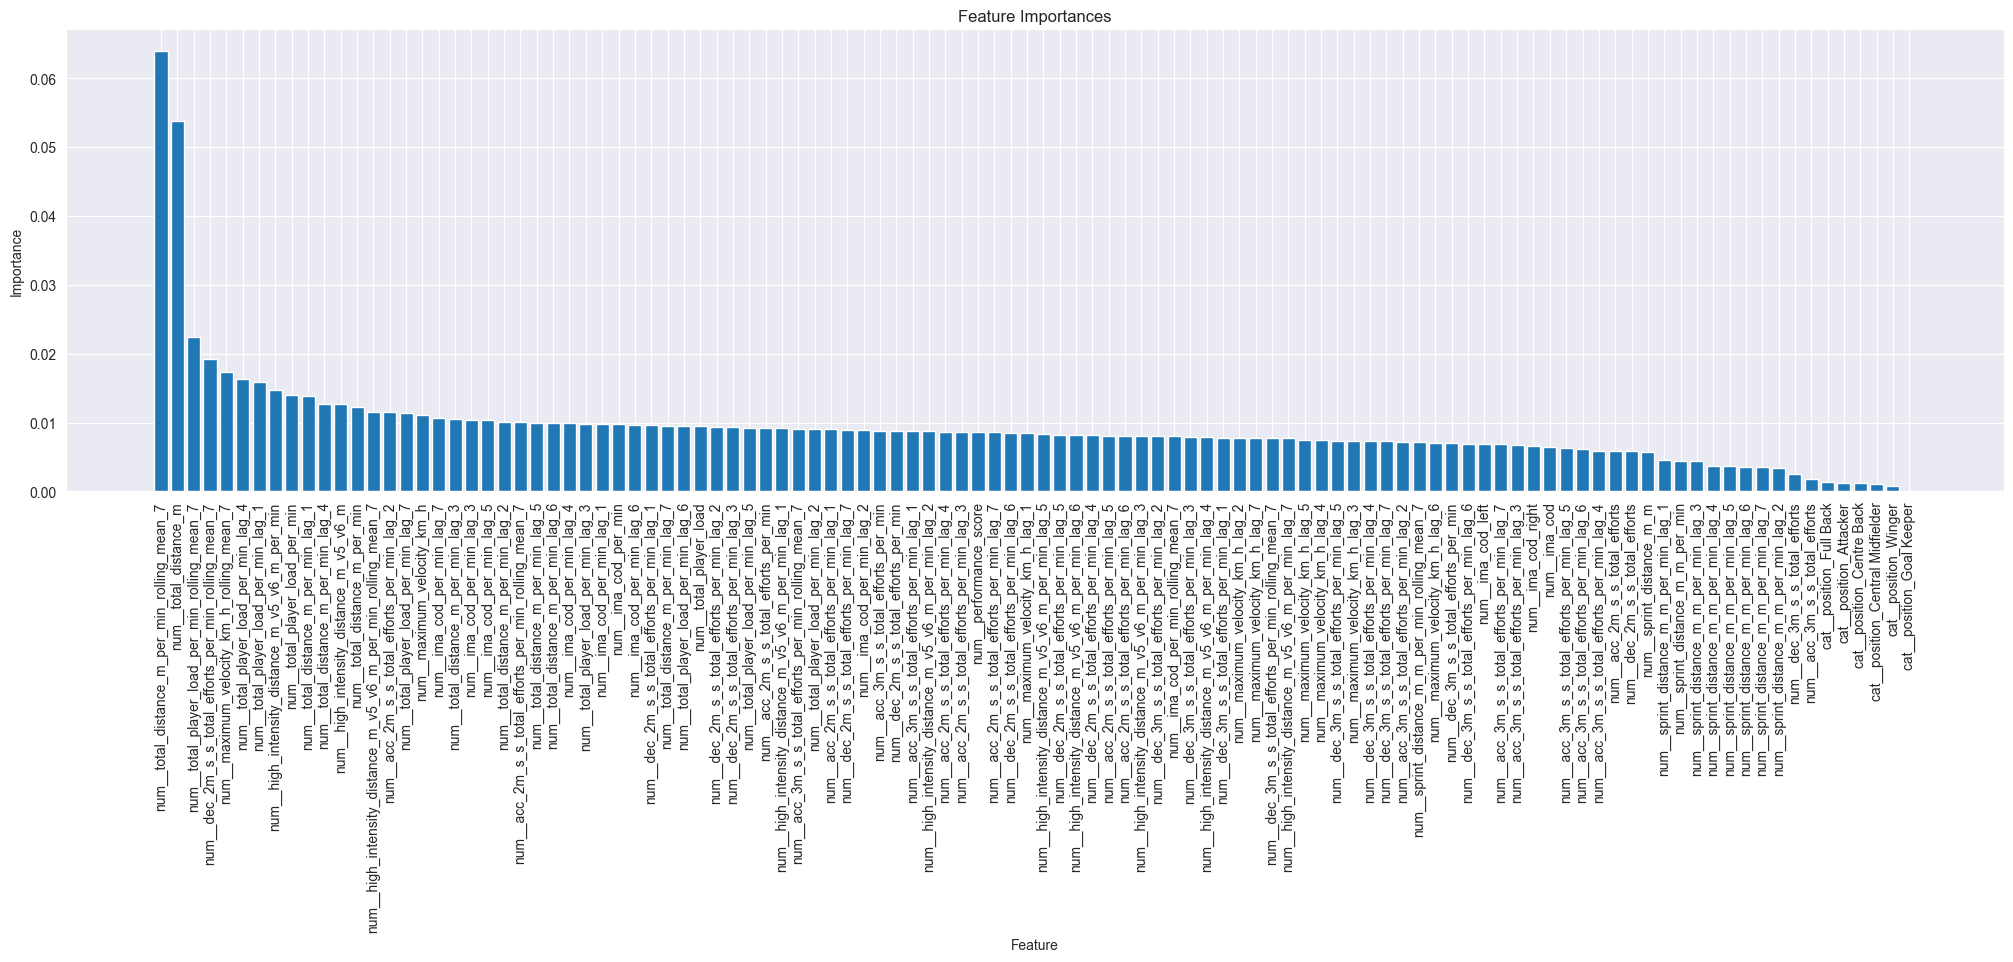

In [7]:
# Finding the most important features.
rf_model = pipeline.named_steps['model']
importances = rf_model.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(25, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()